In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from torchvision import transforms, models

torch.manual_seed(999999999)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Pipeline for preprocessing of the image. 
transform = transforms.Compose([
    transforms.ToPILImage(),            # numpy -> PIL image
    transforms.Resize((224, 224)),      # resize to match ImageNet input
    transforms.RandomHorizontalFlip(),  # simple augmentation
    transforms.ToTensor(),              # [0,255] -> [0,1] + C,H,W
    transforms.Normalize(               # ImageNet mean/std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [4]:
class H5CatDataset(Dataset):
    def __init__(self, h5_path, x_key, y_key, indices=None, transform=None):
        super().__init__()
        self.file_path = h5_path
        self.x_key = x_key
        self.y_key = y_key
        self.transform = transform

        with h5py.File(self.file_path, "r") as f:
            X = f[x_key][:]    # (N, 64, 64, 3)
            y = f[y_key][:]    # (N,)
        self.X = X
        self.y = y.astype(np.float32)

        if indices is None:
            self.indices = np.arange(len(self.y))
        else:
            self.indices = np.array(indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]          # index into original array
        img = self.X[true_idx]               # (64,64,3), uint8
        label = self.y[true_idx]             # scalar 0 or 1

        if self.transform is not None:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)
        return img, label, true_idx          # also return original index


In [5]:
def create_model():
    # ResNet from torchvision
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)  # binary classification
    return model

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

criterion = nn.BCEWithLogitsLoss()  # compatible with single-logit output

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels, _ in loader:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)  # (B, 1)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)


def evaluate(model, loader, device):
    """
    Returns:
      y_true: np.array of shape (N,)
      y_pred: np.array of shape (N,)
      mis_idx_dataset: indices 0..N-1 where prediction != label
      mis_idx_original: corresponding original indices from dataset (true_idx)
    """
    model.eval()
    all_labels = []
    all_preds = []
    all_orig_indices = []

    with torch.no_grad():
        for batch_i, (images, labels, orig_idx) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_orig_indices.append(orig_idx.numpy())

    y_true = np.vstack(all_labels).ravel()
    y_pred = np.vstack(all_preds).ravel()
    orig_idx_all = np.concatenate(all_orig_indices)

    mis_mask = (y_true != y_pred)
    mis_idx_dataset = np.where(mis_mask)[0]   # 0-based indices in *this* test set
    mis_idx_original = orig_idx_all[mis_mask] # original indices (e.g. 0..208)

    return y_true, y_pred, mis_idx_dataset, mis_idx_original


def show_misclassified_images(dataset, mis_idx_dataset, y_pred, num_to_show=4, title_prefix=""):
    num_to_show = min(num_to_show, len(mis_idx_dataset))
    if num_to_show == 0:
        print("No misclassified samples.")
        return

    fig, axes = plt.subplots(1, num_to_show, figsize=(4 * num_to_show, 4))
    if num_to_show == 1:
        axes = [axes]

    for ax, ds_idx in zip(axes, mis_idx_dataset[:num_to_show]):
        img_tensor, label, orig_idx = dataset[ds_idx]

        # unnormalize for display
        img_np = img_tensor.numpy()
        mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std  = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        img_np = img_np * std + mean
        img_np = np.clip(img_np, 0, 1)
        img_np = np.transpose(img_np, (1, 2, 0))

        ax.imshow(img_np)
        ax.axis("off")
        ax.set_title(f"orig idx: {orig_idx}\ntrue: {int(label)} pred: {int(y_pred[ds_idx])}")

    plt.suptitle(title_prefix + " Misclassified Images")
    plt.show()

Using device: cpu


In [20]:
# Original split: full training set vs full test set
train_dataset_orig = H5CatDataset(
    h5_path="train_catvnoncat.h5",
    x_key="train_set_x",
    y_key="train_set_y",
    indices=None,
    transform=transform
)

test_dataset_orig = H5CatDataset(
    h5_path="test_catvnoncat.h5",
    x_key="test_set_x",
    y_key="test_set_y",
    indices=None,
    transform=transform
)

train_loader_orig = DataLoader(train_dataset_orig, batch_size=16, shuffle=False)
test_loader_orig  = DataLoader(test_dataset_orig,  batch_size=16, shuffle=False)

print("Original train size:", len(train_dataset_orig))
print("Original test size:", len(test_dataset_orig))

Original train size: 209
Original test size: 50


In [21]:
model_orig = create_model().to(device)
optimizer_orig = optim.Adam(model_orig.parameters(), lr=1e-5)
scheduler_orig = optim.lr_scheduler.StepLR(optimizer_orig, step_size=5, gamma=0.1)

num_epochs = 1
train_losses_orig = []

for epoch in range(num_epochs):
    loss = train_one_epoch(model_orig, train_loader_orig, optimizer_orig, device)
    train_losses_orig.append(loss)
    scheduler_orig.step()
    print(f"[Original] Epoch {epoch+1}/{num_epochs}, Train Loss: {loss:.4f}")

[Original] Epoch 1/1, Train Loss: 0.6749


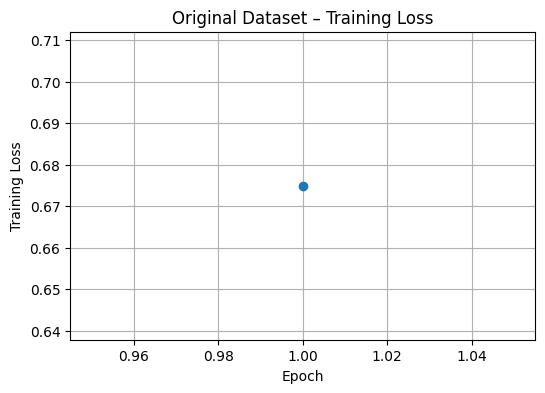

In [22]:
# Plot training loss for original dataset
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), train_losses_orig, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Original Dataset – Training Loss")
plt.grid(True)
plt.show()

In [23]:
y_true_o, y_pred_o, mis_idx_ds_o, mis_idx_orig_o = evaluate(model_orig, test_loader_orig, device)

test_acc_o = (y_true_o == y_pred_o).mean()
print(f"[Original] Test accuracy: {test_acc_o*100:.2f}%")

print("\n[Original] Classification report on TEST set:")
print(classification_report(y_true_o, y_pred_o, target_names=["non-cat", "cat"]))

# Requirement 2: report indices (0-based) of ALL misclassified test images
print("\n[Original] Misclassified TEST indices (dataset indices 0..49):")
print(mis_idx_ds_o)

print("\n[Original] Misclassified TEST original indices (also 0..49 for this dataset):")
print(mis_idx_orig_o)

[Original] Test accuracy: 82.00%

[Original] Classification report on TEST set:
              precision    recall  f1-score   support

     non-cat       0.83      0.59      0.69        17
         cat       0.82      0.94      0.87        33

    accuracy                           0.82        50
   macro avg       0.82      0.76      0.78        50
weighted avg       0.82      0.82      0.81        50


[Original] Misclassified TEST indices (dataset indices 0..49):
[ 5 27 29 34 35 39 41 45 47]

[Original] Misclassified TEST original indices (also 0..49 for this dataset):
[ 5 27 29 34 35 39 41 45 47]


In [24]:
def show_misclassified_images(dataset, mis_idx_dataset, y_pred, num_to_show=4, title_prefix=""):
    num_to_show = min(num_to_show, len(mis_idx_dataset))
    if num_to_show == 0:
        print("No misclassified samples to display.")
        return

    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std  = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

    fig, axes = plt.subplots(1, num_to_show, figsize=(4 * num_to_show, 4))
    if num_to_show == 1:
        axes = [axes]

    for ax, ds_idx in zip(axes, mis_idx_dataset[:num_to_show]):
        img_tensor, label, orig_idx = dataset[ds_idx]

        # Unnormalize
        img = img_tensor.numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))  # CHW -> HWC

        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"orig idx: {orig_idx}\ntrue: {int(label)} pred: {int(y_pred[ds_idx])}",
            fontsize=10
        )

    # Nice, non-overlapping overall title
    fig.suptitle(f"{title_prefix} Misclassified Images", fontsize=14, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

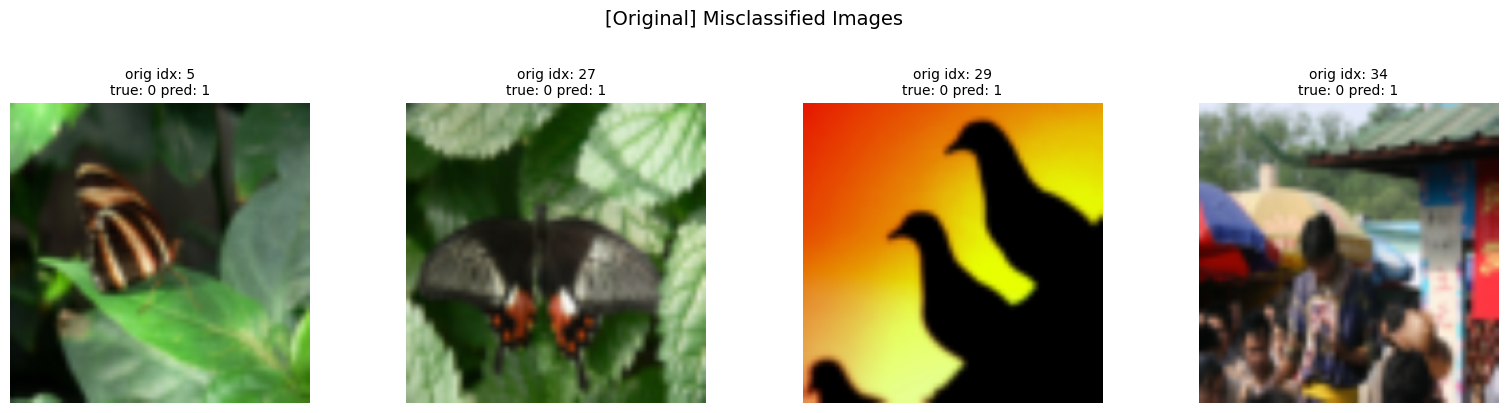

In [25]:
# Requirement 2: display 4 of these failed cases
show_misclassified_images(
    dataset=test_dataset_orig,
    mis_idx_dataset=mis_idx_ds_o,
    y_pred=y_pred_o,
    num_to_show=4,
    title_prefix="[Original]"
)